# PetFinder.my Adoption Prediction

**Description.**

Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. If homes can be found for them, many precious lives can be saved — and more happy families created.

PetFinder.my has been Malaysia’s leading animal welfare platform since 2008, with a database of more than 150,000 animals. PetFinder collaborates closely with animal lovers, media, corporations, and global organizations to improve animal welfare.

Animal adoption rates are strongly correlated to the metadata associated with their online profiles, such as descriptive text and photo characteristics. As one example, PetFinder is experimenting with a simple AI tool called the Cuteness Meter, which ranks how cute a pet is based on qualities present in their photos.

In this project we will be developing an algorithm to predict the adoptability of pets - specifically, how quickly is a pet adopted?

This project was made for the [Kaggle competition](https://www.kaggle.com/c/petfinder-adoption-prediction/overview).

# Read in and Explore the Data

In [44]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
import glob 
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from collections import Counter
from functools import partial
from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
import time
import json
from PIL import Image
import os
from typing import List, Tuple

In this competition we need to predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder. The data includes text, tabular, and image data.

In [2]:
train_data = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
test_data = pd.read_csv('../input/petfinder-adoption-prediction/test/test.csv')

print('Number of training samples is', train_data.shape[0])
print('x (the features) dimensionality is', test_data.columns.shape[0])
print('Number of test samples is', test_data.shape[0])

Number of training samples is 14993
x (the features) dimensionality is 23
Number of test samples is 3972


In [3]:
train_data.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

**Column descriptions:**

PetID - Unique hash ID of pet profile

AdoptionSpeed - Categorical speed of adoption (lower is faster)

Type - Type of animal (1 = Dog, 2 = Cat)

Name - Name of pet (Empty if not named)

Age - Age of pet when listed, in months

Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)

Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)

Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)

Color1 - Color 1 of pet (Refer to ColorLabels dictionary)

Color2 - Color 2 of pet (Refer to ColorLabels dictionary)

Color3 - Color 3 of pet (Refer to ColorLabels dictionary)

MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)

Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)

Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)

Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

Quantity - Number of pets represented in profile

Fee - Adoption fee (0 = Free)

State - State location in Malaysia (Refer to StateLabels dictionary)

RescuerID - Unique hash ID of rescuer

VideoAmt - Total uploaded videos for this pet

PhotoAmt - Total uploaded photos for this pet

Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

In [4]:
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(1269, 412)

Let's seperate target variable from the training dataset and combine the copies of train and test datasets for further data exploration.

In [5]:
train_df = train_data
train_target = train_df['AdoptionSpeed']
train_df = train_df.drop(columns=['AdoptionSpeed'])

train_id = train_df['PetID']
test_id = test_data['PetID']

In [6]:
train_d = train_data.copy()
test_d = test_data.copy()
train_d['dataset_type'] = 'train'
test_d['dataset_type'] = 'test'
all_data = pd.concat([train_d, test_d])

Text(0.5, 1.0, 'Target Value Counts')

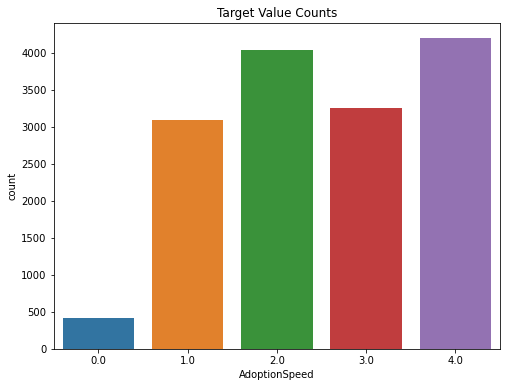

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='AdoptionSpeed', data=all_data)
plt.title("Target Value Counts")

Target is Adoption Speed:

0 - Pet was adopted on the same day as it was listed.

1 - Pet was adopted between 1 and 7 days (1st week) after being listed.

2 - Pet was adopted between 8 and 30 days (1st month) after being listed.

3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.

4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).


As we can see, only a small number of pets have been adopted on the same day as it was listed. Target values are unbalanced but oversampling/undersampling didn't seem to help so we're going to leave it as it is.

Text(0.5, 1.0, 'Number of cats and dogs in train and test data')

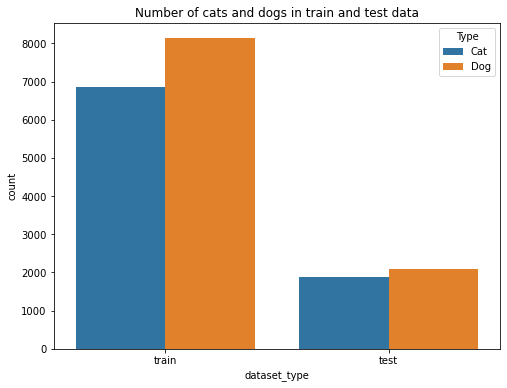

In [8]:
all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(8, 6))
sns.countplot(x='dataset_type', data=all_data, hue='Type')
plt.title('Number of cats and dogs in train and test data')

Train and test datasets both have more dogs than cats but the difference isn't that big. Let's see if adoption speeds are the same for dogs and cats.

Text(0.5, 1.0, 'Adoption speed by pet type')

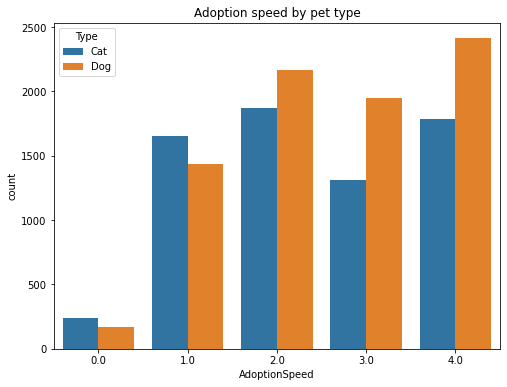

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='AdoptionSpeed', data=all_data, hue='Type')
plt.title('Adoption speed by pet type')

Cats are more likely to get adopted in the first week after being listed.

Most pets are young. However, some data seems to be wrong. For example, there are 545 pets that are 36 years old. This number seems to be too high for a dog or cat.

Text(0.5, 1.0, 'Number of Colors')

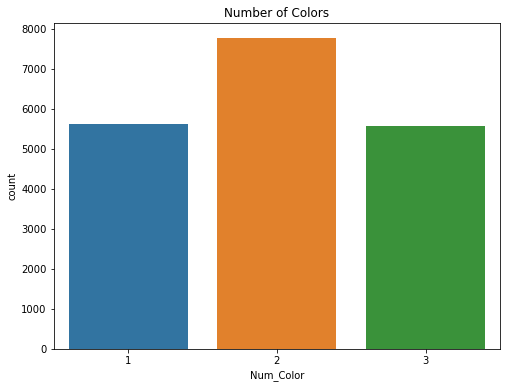

In [10]:
all_data['Num_Color'] = all_data.apply(lambda x:  3-sum([y==0 for y in [x.Color1, x.Color2, x.Color3]]), axis=1)

plt.figure(figsize=(8, 6))
sns.countplot(x='Num_Color', data=all_data)
plt.title("Number of Colors")

Most pets have 2 colors. The number of color might be a significant feature for model training. Let's see what colors are the most frequent.

In [11]:
color_label = pd.read_csv('../input/petfinder-adoption-prediction/color_labels.csv')
color1_count = all_data.Color1.value_counts().reset_index().join(color_label.set_index('ColorID'),on='index').rename(
    columns={'index':'Color1','Color1':'Count'})

color2_count = all_data.Color2.value_counts().reset_index().join(color_label.set_index('ColorID'),on='index').rename(
    columns={'index':'Color2','Color2':'Count'})

color3_count = all_data.Color3.value_counts().reset_index().join(color_label.set_index('ColorID'),on='index').rename(
    columns={'index':'Color3','Color3':'Count'})


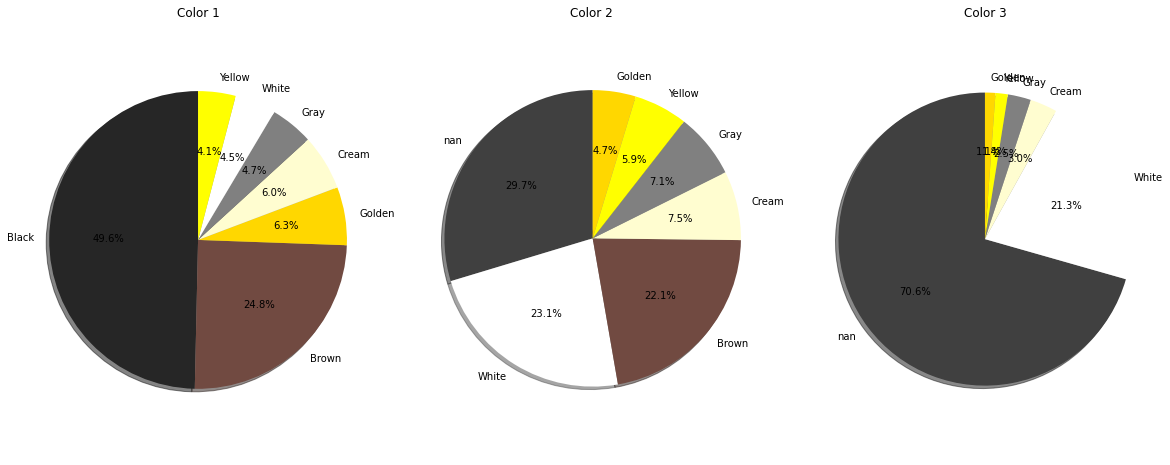

In [12]:
palette1=['#262626', '#714a41', 'Gold', '#FFFDD0', 'Gray', 'White', 'Yellow']
palette2=['#404040', 'White', '#714a41', '#FFFDD0', 'Gray', 'Yellow', 'Gold']
palette3=['#404040', 'White', '#FFFDD0', 'Gray', 'Yellow', 'Gold']

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))

ax1.pie(color1_count.Count, labels=color1_count.ColorName, colors=palette1, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Color 1')
ax1.axis('equal') 

ax2.pie(color2_count.Count, labels=color2_count.ColorName, colors=palette2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.set_title('Color 2')
ax2.axis('equal')


ax3.pie(color3_count.Count, labels=color3_count.ColorName, colors=palette3, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.set_title('Color 3')
ax3.axis('equal')
plt.show()

Dark colours(black, brown) are the most frequent. White is the most frequent second or third color. 

Text(0.5, 1.0, 'Count of Maturity Size')

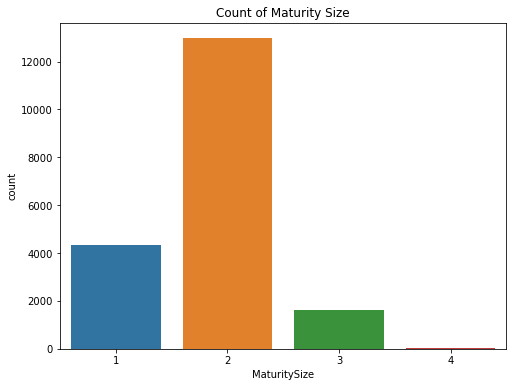

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='MaturitySize', data=all_data)
plt.title("Count of Maturity Size")

* 1 = Small
* 2 = Medium
* 3 = Large
* 4 = Extra Large

The majority of pets are medium size.

# Extracting data from json files

First, we should extract useful information from provided json files:
- **Sentiment Data.** Each pet profile's description has been run through Google's Natural Language API, providing analysis on sentiment and key entities. We're only going to extract the documents sentiment score and magnitude because these are the features that help to improve the predictions the most.

    The score of a document's sentiment indicates the overall emotion of a document. The magnitude of a document's sentiment indicates how much emotional content is present within the document.


In [20]:
def extract_sentiment(dataset: pd.DataFrame, ids: pd.Series, folder: str) -> pd.DataFrame:
    """
    Extracts sentiment score and magnitude from the json file.
    """
    doc_sent_mag = []
    doc_sent_score = []    
    nf_count = 0
    for pet in ids:
        try:
            with open(f'../input/petfinder-adoption-prediction/{folder}/' + pet + '.json', 'r') as f:
                sentiment = json.load(f)
                file_sentiment = sentiment['documentSentiment']
                doc_sent_mag.append(file_sentiment['magnitude'])
                doc_sent_score.append(file_sentiment['score'])
   
        except FileNotFoundError:
                nf_count += 1
                doc_sent_mag.append(-1)
                doc_sent_score.append(-1)

    dataset['doc_sent_mag'] = doc_sent_mag
    dataset['doc_sent_score'] = doc_sent_score
    
    return dataset

In [21]:
train_sent = extract_sentiment(train_df, train_id, 'train_sentiment')
test_sent = extract_sentiment(test_data, test_id, 'test_sentiment')

- **Image Metadata.** Each image has been run through Google's Vision API, providing analysis on Face Annotation, Label Annotation, Text Annotation and Image Properties. Some pets have more than one image. However, we're going to extract data from only the first one because extracting data from all of the images and finding the mean only took more time and didn't help the predictions.

We're going to extract data such as crop hints (coordinates for a bounding box cropped around the dominant object or face in the image), dominant colors of the image, label annotations and score.

In [22]:
def extract_metadata(dataset: pd.DataFrame, ids: pd.Series, folder: str) -> pd.DataFrame:
    """
    Extracts image metadata from the json file. Takes data only from the first image of a profile.
    """
    vertex_xs = []
    vertex_ys = []
    bounding_confidences = []
    bounding_importance_fracs = []
    dominant_blues = []
    dominant_greens = []
    dominant_reds = []
    dominant_pixel_fracs = []
    dominant_scores = []
    label_descriptions = []
    label_scores = []
    nf_count = 0
    separator = ' '
    nl_count = 0
    for pet in ids:
        try:
            with open(f'../input/petfinder-adoption-prediction/{folder}/' + pet + '-1.json', 'r') as f:
                data = json.load(f)
            vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
            vertex_xs.append(vertex_x)
            vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
            vertex_ys.append(vertex_y)
            bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
            bounding_confidences.append(bounding_confidence)
            bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
            bounding_importance_fracs.append(bounding_importance_frac)
            dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
            dominant_blues.append(dominant_blue)
            dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
            dominant_greens.append(dominant_green)
            dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
            dominant_reds.append(dominant_red)
            dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
            dominant_pixel_fracs.append(dominant_pixel_frac)
            dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
            dominant_scores.append(dominant_score)

            if data.get('labelAnnotations'):
                label_description = data['labelAnnotations'][0]['description']
                label_descriptions.append(label_description)
                label_score = data['labelAnnotations'][0]['score']
                label_scores.append(label_score)
            else:
                nl_count += 1
                label_descriptions.append('nothing')
                label_scores.append(-1)
        except FileNotFoundError:
            nf_count += 1
            vertex_xs.append(-1)
            vertex_ys.append(-1)
            bounding_confidences.append(-1)
            bounding_importance_fracs.append(-1)
            dominant_blues.append(-1)
            dominant_greens.append(-1)
            dominant_reds.append(-1)
            dominant_pixel_fracs.append(-1)
            dominant_scores.append(-1)
            label_descriptions.append('nothing')
            label_scores.append(-1)


    dataset['meta_vertex_x'] = vertex_xs
    dataset['meta_vertex_y'] = vertex_ys
    dataset['meta_bounding_confidence'] = bounding_confidences
    dataset['meta_bounding_importance'] = bounding_importance_fracs
    dataset['meta_dominant_blue'] = dominant_blues
    dataset['meta_dominant_green'] = dominant_greens
    dataset['meta_dominant_red'] = dominant_reds
    dataset['meta_dominant_pixel_frac'] = dominant_pixel_fracs
    dataset['meta_dominant_score'] = dominant_scores
    dataset['meta_label_description'] = label_descriptions
    dataset['meta_label_score'] = label_scores
    
    return dataset

In [23]:
test_meta = extract_metadata(test_sent, test_id, 'test_metadata')
train_meta = extract_metadata(train_sent, train_id, 'train_metadata')

# Creating new features

Next, we should create some additional useful features that are going to help to improve the predictions.

In [24]:
train_meta.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'doc_sent_mag',
       'doc_sent_score', 'meta_vertex_x', 'meta_vertex_y',
       'meta_bounding_confidence', 'meta_bounding_importance',
       'meta_dominant_blue', 'meta_dominant_green', 'meta_dominant_red',
       'meta_dominant_pixel_frac', 'meta_dominant_score',
       'meta_label_description', 'meta_label_score'],
      dtype='object')

We are going to convert the description data to a matrix of TF-IDF features, using [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and then reduce dimensionality with [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html?highlight=truncatedsvd#sklearn.decomposition.TruncatedSVD) because it can work with sparse matrices efficiently.  We are going to output 40 features from the *Description* column.

In [25]:
def description_features(dataset: pd.DataFrame, SVD_COMPONENTS: int=40) -> pd.DataFrame:
    """
    convert the description data to a matrix of TF-IDF features and reduces dimensionality.
    """
    dataset_desc = dataset.Description.fillna("none").values
    tfv = TfidfVectorizer(min_df=2,  max_features=None,
        strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
        ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
        stop_words = 'english')
    X = tfv.fit_transform(list(dataset_desc))
    
    svd = TruncatedSVD(n_components=SVD_COMPONENTS)
    X = svd.fit_transform(X)
    X = pd.DataFrame(X, columns=['svd_{}'.format(i) for i in range(SVD_COMPONENTS)])
    dataset_full = pd.concat((dataset, X), axis=1)
    
    return dataset_full

SVD_COMPONENTS=40
train_text = description_features(train_meta)
test_text = description_features(test_meta)

Now let's get some additional features from the image files. We are going to get the size and dimensions of the images. Some pets have multiple images, so we need to used aggregate functions (sum, mean and variance).

In [47]:
train_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_images/' + '*.jpg'))
test_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_images/' + '*.jpg'))

def getSize(filename: str) -> int:
    """
    Gets the size of the file.
    """
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename: str) -> Tuple[int, int]:
    """
    Gets the dimensions of the image.
    """
    img_size = Image.open(filename).size
    return img_size 

In [48]:
def extra_features(dataset: pd.DataFrame, image_files: List[str]) -> pd.DataFrame:
    """
    Calculates extra image file size, width and height features.
    """
    split_char = '/'
    df_imgs = pd.DataFrame(image_files)
    df_imgs.columns = ['image_filename']
    imgs_pets = df_imgs['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])
    
    df_imgs = df_imgs.assign(PetID=imgs_pets)
    df_imgs['image_size'] = df_imgs['image_filename'].apply(getSize)
    df_imgs['temp_size'] = df_imgs['image_filename'].apply(getDimensions)
    df_imgs['width'] = df_imgs['temp_size'].apply(lambda x : x[0])
    df_imgs['height'] = df_imgs['temp_size'].apply(lambda x : x[1])
    df_imgs = df_imgs.drop(['temp_size'], axis=1)
    aggs = {
        'image_size': ['sum', 'mean', 'var'],
        'width': ['sum', 'mean', 'var'],
        'height': ['sum', 'mean', 'var'],
    }

    agg_imgs = df_imgs.groupby('PetID').agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_imgs.columns = new_columns
    agg_imgs = agg_imgs.reset_index()
    dataset = dataset.merge(agg_imgs, how='left', on='PetID')
    
    return dataset

In [49]:
train_text = extra_features(train_text, train_image_files)
test_text = extra_features(test_text, test_image_files)

In [50]:
train_text.isnull().sum().sum(), test_text.isnull().sum().sum()

(13563, 4258)

In [51]:
for i in ['Description', 'Name']:
    train_text.loc[:, i] = train_text.loc[:, i].fillna('')
    test_text.loc[:, i] = test_text.loc[:, i].fillna('')

train_text = train_text.fillna(-1)
test_text = test_text.fillna(-1)

train_text.isnull().sum().sum(), test_text.isnull().sum().sum()

(0, 0)

In [52]:
for dataset in [train_text, test_text]:
    text_columns = ['Description','Name', 'meta_label_description']
    dataset[text_columns] = dataset[text_columns].astype('string')
    dataset['Length_Description'] = dataset['Description'].map(len)
    dataset['Length_Name'] = dataset['Name'].map(len)
    dataset['Length_meta_label_description'] = dataset['meta_label_description'].map(len)
    
    dataset['Second_color_mixed'] = dataset['Color2']*10 + dataset['Color3']
    dataset['Breed1_Cat'] = dataset['Breed1'][dataset['Type']==1]
    dataset['Breed1_Dog'] = dataset['Breed1'][dataset['Type']==2]
    dataset['Breed2_Cat'] = dataset['Breed2'][dataset['Type']==1]
    dataset['Breed2_Dog'] = dataset['Breed2'][dataset['Type']==2]
    dataset['age_bins'] = pd.cut(dataset['Age'],5,labels=[1,2,3,4,5]).astype(int)
    dataset['gender_age_bins'] = dataset['Gender']*10+dataset['age_bins']
    
    rescuer_count = dataset.groupby(['RescuerID'])['PetID'].count()
    rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']
    dataset['Rescuer_count'] = dataset['RescuerID'].map(rescuer_count.to_dict())
    
    new_feat = ['Breed1_Cat', 'Breed1_Dog', 'Breed2_Cat', 'Breed2_Dog', 'age_bins', 'gender_age_bins']
    dataset[new_feat] = dataset[new_feat].fillna(-1)

In [53]:
train_text.drop(['Name', 'Description', 'RescuerID', 'PetID'], axis=1, inplace=True)
test_text.drop(['Name', 'Description', 'RescuerID', 'PetID'], axis=1, inplace=True)
numeric_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'doc_sent_mag', 'doc_sent_score',
                'meta_dominant_score', 'meta_dominant_pixel_frac', 'meta_dominant_red', 'meta_dominant_green',
                'meta_dominant_blue', 'meta_bounding_importance', 'meta_bounding_confidence', 'meta_vertex_x',
                'meta_vertex_y', 'meta_label_score', 'Length_meta_label_description', 'Length_Description', 
                'image_size_sum', 'image_size_mean', 'image_size_var', 'width_sum', 'width_mean',
                'width_var', 'height_sum', 'height_mean', 'height_var', 'Second_color_mixed',
                'Rescuer_count' ]  +  ['svd_{}'.format(i) for i in range(SVD_COMPONENTS)]

cat_cols = list(set(train_text.columns) - set(numeric_cols) )
train_text.loc[:, cat_cols] = train_text[cat_cols].astype('category')
test_text.loc[:, cat_cols] = test_text[cat_cols].astype('category')
print(train_text.shape)
print(test_text.shape)

(14993, 92)
(3972, 92)


In [54]:
cat_feature_names = train_text.dtypes[train_text.dtypes == "category"]
cat_features = [train_text.columns.get_loc(c) for c in train_text.columns if c in cat_feature_names]

# Modeling

Submissions for this competition are scored based on the [quadratic weighted kappa](https://www.kaggle.com/c/petfinder-adoption-prediction/overview/evaluation), which measures the agreement between two ratings.

In [95]:
def confusion_matrix(rater_a: np.ndarray, rater_b: np.ndarray, min_rating: int=None, max_rating: int=None) -> List:
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings: np.ndarray, min_rating: int=None, max_rating:int=None) -> List:
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for rating in ratings:
        hist_ratings[rating - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y: pd.Series, y_pred: np.ndarray) -> float:
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """    
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items
    return (1.0 - numerator / denominator)

For better results, we are going to use the OptimizedRounder class to find the best coefficients and round the predictions.

In [100]:
class OptimizedRounder(object):
    """
    Class for finding the best coefficients and rounding the predictions.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))    

## LGB

For modeling we are going to use cross validation with 5 folds.

In [108]:
N_SPLITS = 5
def run_cv_model(train: pd.DataFrame, test: pd.DataFrame, target: pd.Series, model_fn,
                 params: dict={}, eval_fn=None, label: str='model'):
    """
    Returns predictions on train and test datasets, cross validation scores, 
    quadratic weighted kappa scores and OptimizedRounder coefficients
    """
    kf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    fold_splits = kf.split(train, target)
    cv_scores = []
    qwk_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0], N_SPLITS))
    all_coefficients = np.zeros((N_SPLITS, 4))
    i = 1
    
    # Split train dataset and target into training and validation sets
    for train_index, val_index in fold_splits:
        print('Started ' + label + ' fold ' + str(i) + '/' + str(N_SPLITS))
        if isinstance(train, pd.DataFrame):
            train_X, val_X = train.iloc[train_index], train.iloc[val_index]
            train_y, val_y = target[train_index], target[val_index]
        else:
            train_X, val_X = train[train_index], train[val_index]
            train_y, val_y = target[train_index], target[val_index]
       
        # Train model and make predictions
        params2 = params.copy()
        pred_val_y, pred_test_y, model, coefficients, qwk, time = model_fn(train_X, train_y, val_X, val_y, test, params2)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        all_coefficients[i-1, :] = coefficients
        
        # Validation scores
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            qwk_scores.append(qwk)
            print(label + ' cv score {}: RMSE {} QWK {}'.format(i, cv_score, qwk))     
        i += 1
        
    print('{} cv RMSE scores : {}'.format(label, cv_scores))
    print('{} cv mean RMSE score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv QWK scores : {}'.format(label, qwk_scores))
    print('{} cv mean QWK score : {}'.format(label, np.mean(qwk_scores)))
    pred_full_test = pred_full_test / float(N_SPLITS)
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores, 'qwk': qwk_scores,
               'coefficients': all_coefficients}
    
    return results, model, np.mean(qwk_scores), time

def runLGB(train_X: pd.DataFrame, train_y: pd.Series, test_X: pd.DataFrame, test_y: pd.Series,
           test_X2: pd.DataFrame, params: dict):
    """
    Trains the LGB model and makes the predictions.
    """
    print('Prep LGB')
    d_train = lgb.Dataset(train_X, label=train_y)
    d_valid = lgb.Dataset(test_X, label=test_y)
    watchlist = [d_train, d_valid]
    
    print('Train LGB')
    num_rounds = params.pop('num_rounds')
    verbose_eval = params.pop('verbose_eval')
    early_stop = None
    if params.get('early_stop'):
        early_stop = params.pop('early_stop')
        
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      categorical_feature=list(cat_features),
                      early_stopping_rounds=early_stop)
    
    print('Predict 1/2')
    start = time.time()
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    stop = time.time()
    time_lgb = stop - start
    print("Model Inference Speed = ", time_lgb)
    optR = OptimizedRounder()
    optR.fit(pred_test_y, test_y)
    coefficients = optR.coefficients()
    pred_test_y_k = optR.predict(pred_test_y, coefficients)
    print("Valid Counts = ", Counter(test_y))
    print("Predicted Counts = ", Counter(pred_test_y_k))
    print("Coefficients = ", coefficients)
    qwk = quadratic_weighted_kappa(test_y, pred_test_y_k)
    print("QWK = ", qwk)
    
    print('Predict 2/2')
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
    
    return pred_test_y.reshape(-1, 1), pred_test_y2.reshape(-1, 1), model, coefficients, qwk, time_lgb

In [109]:
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17,
          'early_stop': 600,
          'verbose_eval': 100,
          'num_rounds': 10000}

In [111]:
results_lgb, model_lgb, qwk_lgb, time_lgb = run_cv_model(train_text, test_text, train_target, runLGB, params, rmse, 'lgb')

Started lgb fold 1/5
Prep LGB
Train LGB


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 30, 82, 85, 86, 87, 88, 89, 90]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 600 rounds
[100]	training's rmse: 1.0445	valid_1's rmse: 1.08813
[200]	training's rmse: 0.981958	valid_1's rmse: 1.06226
[300]	training's rmse: 0.942513	valid_1's rmse: 1.05101
[400]	training's rmse: 0.912657	valid_1's rmse: 1.04465
[500]	training's rmse: 0.890542	valid_1's rmse: 1.04131
[600]	training's rmse: 0.870936	valid_1's rmse: 1.03876
[700]	training's rmse: 0.85494	valid_1's rmse: 1.03734
[800]	training's rmse: 0.838233	valid_1's rmse: 1.03593
[900]	training's rmse: 0.818895	valid_1's rmse: 1.03474
[1000]	training's rmse: 0.80293	valid_1's rmse: 1.03413
[1100]	training's rmse: 0.786394	valid_1's rmse: 1.03351
[1200]	training's rmse: 0.770533	valid_1's rmse: 1.03292
[1300]	training's rmse: 0.755525	valid_1's rmse: 1.03235
[1400]	training's rmse: 0.740627	valid_1's rmse: 1.03213
[1500]	training's rmse: 0.725123	valid_1's rmse: 1.03126
[1600]	training's rmse: 0.709761	valid_1's rmse: 1.03079
[1700]	training's rmse: 0.697033	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 30, 82, 85, 86, 87, 88, 89, 90]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 600 rounds
[100]	training's rmse: 1.04569	valid_1's rmse: 1.08194
[200]	training's rmse: 0.984175	valid_1's rmse: 1.05328
[300]	training's rmse: 0.943759	valid_1's rmse: 1.03998
[400]	training's rmse: 0.914621	valid_1's rmse: 1.03357
[500]	training's rmse: 0.891648	valid_1's rmse: 1.031
[600]	training's rmse: 0.869889	valid_1's rmse: 1.02903
[700]	training's rmse: 0.850796	valid_1's rmse: 1.02756
[800]	training's rmse: 0.833908	valid_1's rmse: 1.02679
[900]	training's rmse: 0.817295	valid_1's rmse: 1.02574
[1000]	training's rmse: 0.801489	valid_1's rmse: 1.02455
[1100]	training's rmse: 0.78336	valid_1's rmse: 1.02377
[1200]	training's rmse: 0.76888	valid_1's rmse: 1.02303
[1300]	training's rmse: 0.754086	valid_1's rmse: 1.02213
[1400]	training's rmse: 0.740138	valid_1's rmse: 1.02153
[1500]	training's rmse: 0.72467	valid_1's rmse: 1.02095
[1600]	training's rmse: 0.711012	valid_1's rmse: 1.02075
[1700]	training's rmse: 0.69811	valid_1's

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 30, 82, 85, 86, 87, 88, 89, 90]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 600 rounds
[100]	training's rmse: 1.04632	valid_1's rmse: 1.08814
[200]	training's rmse: 0.984038	valid_1's rmse: 1.05974
[300]	training's rmse: 0.942928	valid_1's rmse: 1.04496
[400]	training's rmse: 0.913145	valid_1's rmse: 1.03736
[500]	training's rmse: 0.888702	valid_1's rmse: 1.03205
[600]	training's rmse: 0.867421	valid_1's rmse: 1.02881
[700]	training's rmse: 0.848538	valid_1's rmse: 1.02671
[800]	training's rmse: 0.830351	valid_1's rmse: 1.02538
[900]	training's rmse: 0.81253	valid_1's rmse: 1.02426
[1000]	training's rmse: 0.795155	valid_1's rmse: 1.02309
[1100]	training's rmse: 0.778216	valid_1's rmse: 1.02274
[1200]	training's rmse: 0.763357	valid_1's rmse: 1.02237
[1300]	training's rmse: 0.749173	valid_1's rmse: 1.02177
[1400]	training's rmse: 0.734401	valid_1's rmse: 1.02119
[1500]	training's rmse: 0.719507	valid_1's rmse: 1.02089
[1600]	training's rmse: 0.705955	valid_1's rmse: 1.02055
[1700]	training's rmse: 0.69292	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 30, 82, 85, 86, 87, 88, 89, 90]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 600 rounds
[100]	training's rmse: 1.04475	valid_1's rmse: 1.09101
[200]	training's rmse: 0.981787	valid_1's rmse: 1.06622
[300]	training's rmse: 0.941944	valid_1's rmse: 1.05548
[400]	training's rmse: 0.912096	valid_1's rmse: 1.0493
[500]	training's rmse: 0.890327	valid_1's rmse: 1.04628
[600]	training's rmse: 0.871921	valid_1's rmse: 1.04415
[700]	training's rmse: 0.853702	valid_1's rmse: 1.04261
[800]	training's rmse: 0.836689	valid_1's rmse: 1.04196
[900]	training's rmse: 0.818162	valid_1's rmse: 1.04084
[1000]	training's rmse: 0.799951	valid_1's rmse: 1.04048
[1100]	training's rmse: 0.782345	valid_1's rmse: 1.04069
[1200]	training's rmse: 0.766861	valid_1's rmse: 1.04058
[1300]	training's rmse: 0.752326	valid_1's rmse: 1.04071
[1400]	training's rmse: 0.737763	valid_1's rmse: 1.041
[1500]	training's rmse: 0.724317	valid_1's rmse: 1.04129
Early stopping, best iteration is:
[986]	training's rmse: 0.802348	valid_1's rmse: 1.04042
Predi

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 30, 82, 85, 86, 87, 88, 89, 90]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 600 rounds
[100]	training's rmse: 1.04542	valid_1's rmse: 1.08518
[200]	training's rmse: 0.983941	valid_1's rmse: 1.05902
[300]	training's rmse: 0.944824	valid_1's rmse: 1.04738
[400]	training's rmse: 0.915892	valid_1's rmse: 1.04229
[500]	training's rmse: 0.893444	valid_1's rmse: 1.03865
[600]	training's rmse: 0.874785	valid_1's rmse: 1.03728
[700]	training's rmse: 0.85682	valid_1's rmse: 1.03622
[800]	training's rmse: 0.840788	valid_1's rmse: 1.03586
[900]	training's rmse: 0.821414	valid_1's rmse: 1.0354
[1000]	training's rmse: 0.803319	valid_1's rmse: 1.0349
[1100]	training's rmse: 0.786803	valid_1's rmse: 1.03411
[1200]	training's rmse: 0.772746	valid_1's rmse: 1.03357
[1300]	training's rmse: 0.757989	valid_1's rmse: 1.03332
[1400]	training's rmse: 0.742344	valid_1's rmse: 1.03292
[1500]	training's rmse: 0.728725	valid_1's rmse: 1.03274
[1600]	training's rmse: 0.714094	valid_1's rmse: 1.03249
[1700]	training's rmse: 0.698836	valid_

# XGB

In [112]:
train_text['meta_label_description'] = pd.factorize(train_text['meta_label_description'])[0]
test_text['meta_label_description'] = pd.factorize(test_text['meta_label_description'])[0]

train_text.loc[:, cat_cols] = train_text[cat_cols].astype('int')
test_text.loc[:, cat_cols] = test_text[cat_cols].astype('int')

In [113]:
params = {
    'eval_metric': 'rmse',
    'seed': 1337,
    'eta': 0.0123,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'tree_method': 'gpu_hist',
    'device': 'gpu',
    'silent': 1,
}
n_splits = 5
verbose_eval = 100
num_rounds = 10000
early_stop = 600

def runXGB(train_X: pd.DataFrame, train_y: pd.Series, test_X: pd.DataFrame, test_y: pd.Series, 
           test_X2: pd.DataFrame, params: dict):
    """
    Trains the XGB model and makes the predictions.
    """
    print('Prep XGB')
    d_train = xgb.DMatrix(data=train_X, label=train_y, feature_names=train_X.columns)
    d_valid = xgb.DMatrix(data=test_X, label=test_y, feature_names=test_X.columns)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    print('Train XGB')

    model = xgb.train(dtrain=d_train, num_boost_round=num_rounds, evals=watchlist,
                      early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params)
    
    print('Predict 1/2')
    start = time.time()
    pred_test_y = model.predict(xgb.DMatrix(test_X, feature_names=test_X.columns), ntree_limit=model.best_ntree_limit)
    stop = time.time()
    time_xgb = stop - start
    print("Model Inference Speed = ", time_xgb)
    
    optR = OptimizedRounder()
    optR.fit(pred_test_y, test_y)
    coefficients = optR.coefficients()
    pred_test_y_k = optR.predict(pred_test_y, coefficients)
    print("Valid Counts = ", Counter(test_y))
    print("Predicted Counts = ", Counter(pred_test_y_k))
    print("Coefficients = ", coefficients)
    qwk = quadratic_weighted_kappa(test_y, pred_test_y_k)
    print("QWK = ", qwk)
    
    print('Predict 2/2')
    pred_test_y2 = model.predict(xgb.DMatrix(test_X2, feature_names=test_X2.columns), ntree_limit=model.best_ntree_limit)
    return pred_test_y.reshape(-1, 1), pred_test_y2.reshape(-1, 1), model,  coefficients, qwk, time_xgb

In [114]:
results_xgb, model_xgb, qwk_xgb, time_xgb = run_cv_model(train_text, test_text, train_target, runXGB, params, rmse, 'xgb')

Started xgb fold 1/5
Prep XGB
Train XGB
[07:44:47] WARNING: ../src/learner.cc:541: 
Parameters: { device, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:2.31237	valid-rmse:2.31234
[100]	train-rmse:1.18021	valid-rmse:1.22974
[200]	train-rmse:0.96966	valid-rmse:1.07365
[300]	train-rmse:0.90406	valid-rmse:1.05106
[400]	train-rmse:0.86172	valid-rmse:1.04348
[500]	train-rmse:0.82910	valid-rmse:1.03923
[600]	train-rmse:0.79826	valid-rmse:1.03639
[700]	train-rmse:0.76871	valid-rmse:1.03445
[800]	train-rmse:0.74210	valid-rmse:1.03290
[900]	train-rmse:0.71689	valid-rmse:1.03115
[1000]	train-rmse:0.69122	valid-rmse:1.03033
[1100]	train-rmse:0.66663	valid-rmse:1.02991
[1200]	train-rmse:0.64157	valid-rmse:1.02956
[1300]	train-rmse:0.61854	valid-rmse:1.02861
[1400]	t

# Random Forest

In [115]:
def runRF(train_X: pd.DataFrame, train_y: pd.Series, test_X: pd.DataFrame, test_y: pd.Series,
          test_X2: pd.DataFrame, params: dict):
    """
    Trains the Random Forest model and makes the predictions.
    """
    print('Train Random Forest')
    model = RandomForestRegressor(n_estimators=200,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1).fit(train_X, train_y)
    
    print('Predict 1/2')
    start = time.time()
    pred_test_y = model.predict(test_X)
    stop = time.time()
    time_rf = stop - start
    print("Model Inference Speed = ", time_rf)
    optR = OptimizedRounder()
    optR.fit(pred_test_y, test_y)
    coefficients = optR.coefficients()
    pred_test_y_k = optR.predict(pred_test_y, coefficients)
    print("Valid Counts = ", Counter(test_y))
    print("Predicted Counts = ", Counter(pred_test_y_k))
    print("Coefficients = ", coefficients)
    qwk = quadratic_weighted_kappa(test_y, pred_test_y_k)
    print("QWK = ", qwk)
    
    print('Predict 2/2')
    pred_test_y2 = model.predict(test_X2)
    return pred_test_y.reshape(-1, 1), pred_test_y2.reshape(-1, 1), model,  coefficients, qwk, time_rf

In [116]:
results_rf, model_rf, qwk_rf, time_rf = run_cv_model(train_text, test_text, train_target, runRF, params, rmse, 'RF')

Started RF fold 1/5
Train Random Forest
Predict 1/2
Model Inference Speed =  0.10526490211486816
Valid Counts =  Counter({4: 839, 2: 808, 3: 652, 1: 618, 0: 82})
Predicted Counts =  Counter({3.0: 995, 1.0: 987, 4.0: 532, 2.0: 485})
Coefficients =  [0.5058513  2.26396507 2.45759435 2.97098377]
QWK =  0.4380022413654966
Predict 2/2
RF cv score 1: RMSE 1.0459393311374312 QWK 0.4380022413654966
Started RF fold 2/5
Train Random Forest
Predict 1/2
Model Inference Speed =  0.10488152503967285
Valid Counts =  Counter({4: 840, 2: 808, 3: 651, 1: 618, 0: 82})
Predicted Counts =  Counter({1.0: 961, 3.0: 794, 4.0: 672, 2.0: 572})
Coefficients =  [0.46589111 2.23029593 2.47347225 2.8608813 ]
QWK =  0.45528831310171414
Predict 2/2
RF cv score 2: RMSE 1.0366375111810398 QWK 0.45528831310171414
Started RF fold 3/5
Train Random Forest
Predict 1/2
Model Inference Speed =  0.10482215881347656
Valid Counts =  Counter({4: 840, 2: 807, 3: 652, 1: 618, 0: 82})
Predicted Counts =  Counter({2.0: 1584, 4.0: 104

## Model Comparison

Now let's compare the results of all the models. Private scores were got by submitting the model prediction on test dataset.

In [117]:
models = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'RandomForestRegressor'],
    'Time': [time_lgb, time_xgb, time_rf],
    'CrossValidation' : [qwk_lgb, qwk_xgb, qwk_rf],
    'Private': [0.3815, 0.3768, 0.3588]})
models.sort_values(by='Private', ascending=False)

,Model,Time,CrossValidation,Private
0,LightGBM,0.483186,0.459247,0.3815
1,XGBoost,0.213460,0.470696,0.3768
2,RandomForestRegressor,0.104911,0.433396,0.3588


LightGBM achieved the best private score but it's also the slowest at making predictions.

# Submission

In [ ]:
optR = OptimizedRounder()
coefficients_ = np.mean(results_lgb['coefficients'], axis=0)
print(coefficients_)
coefficients_[0] = 1.66
coefficients_[1] = 2.13
coefficients_[3] = 2.85
test_predictions = [r[0] for r in results_lgb['test']]
test_predictions = optR.predict(test_predictions, coefficients_).astype(int)
Counter(test_predictions)

In [ ]:
submission = pd.DataFrame({'PetID': test_id, 'AdoptionSpeed': test_predictions})
submission.head()
submission.to_csv('submission.csv', index=False)